In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [2]:
n_in = 1
n_h1 = 5
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))

* Total number of parameters:

In [3]:
print(sum(p.numel() for p in nn_model.parameters()))

22


* Randomly initialise model parameters:

In [4]:
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=2, bias=True)
)

#### Generate some random data:

In [21]:
error_sigma = 1e-1
nobs = 1_000
x = torch.rand(nobs, n_in, requires_grad=True)
xvals = x.data
y = np.zeros((nobs, n_out))
y[:,0] = list(abs(xvals)*np.cos(2*np.pi*xvals))
y[:,1] = list(abs(xvals)*np.sin(2*np.pi*xvals))
y = 3*torch.from_numpy(y).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()

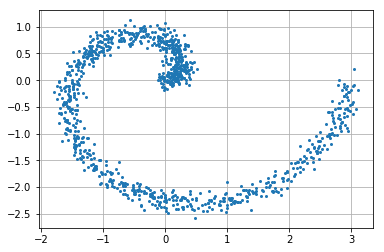

In [22]:
plt.plot(list(y[:,0]), list(y[:,1]), 'o', markersize=2)
plt.grid(True)

In [23]:
update_grads(nn_model, x, y)

* Get dimensions of parameters:

In [7]:
shapes = get_shapes(nn_model)
print("Shapes = ", shapes)

Shapes =  [torch.Size([5, 1]), torch.Size([5]), torch.Size([2, 5]), torch.Size([2])]


###  HMC

In [8]:
T = 1_000
delta_leapfrog = 1e-2
n_leapfrog = 100
prior_sigma = 1
M = torch.eye(n_params(nn_model))

In [9]:
chain = run_HMC(x, y, T, nn_model, n_leapfrog, delta_leapfrog, prior_sigma, error_sigma, M)

iter    100/1000 after    27.1 sec | accept_rate 0.650
iter    200/1000 after    50.6 sec | accept_rate 0.680
iter    300/1000 after    78.4 sec | accept_rate 0.663
iter    400/1000 after   103.2 sec | accept_rate 0.703
iter    500/1000 after   130.1 sec | accept_rate 0.700
iter    600/1000 after   155.9 sec | accept_rate 0.697
iter    700/1000 after   182.5 sec | accept_rate 0.699
iter    800/1000 after   209.7 sec | accept_rate 0.700
iter    900/1000 after   233.6 sec | accept_rate 0.704
iter   1000/1000 after   259.0 sec | accept_rate 0.706


#### ESS's:

In [10]:
ESS = [int(T/gewer_estimate_IAT(chain[:,i].data.numpy())) for i in range(np.shape(chain)[1])]
print(ESS)

[352, 990, 1323, 265, 140, 1147, 1145, 116, 333, 197, 223, 552, 137, 268, 157, 163, 321, 1045, 366, 142, 336, 1117]


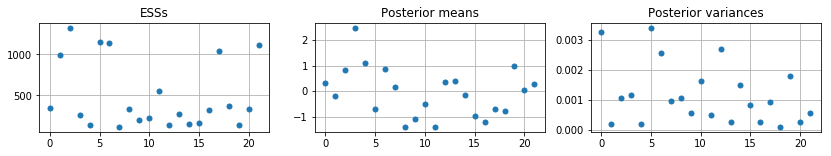

In [12]:
ms = 5
plt.figure(figsize=(14,2))
plt.rcParams['axes.grid'] = True
plt.subplot(131)
plt.plot(ESS, 'o', markersize=ms)
plt.title("ESSs")
plt.subplot(132)
plt.plot(torch.mean(chain,0).data.numpy(), 'o', markersize=ms)
plt.title("Posterior means")
plt.subplot(133)
plt.plot(torch.var(chain,0).data.numpy(), 'o', markersize=ms)
plt.title("Posterior variances");

In [19]:
x.requires_grad

False

In [14]:
np.mean(ESS)

29.681818181818183

In [18]:
%timeit extract_params(nn_model)
%timeit extract_grads(nn_model)
%timeit set_params(torch.randn(n_params(nn_model)), nn_model, x, y) 

28.7 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
21.6 µs ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.14 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
T*n_leapfrog*(1.14/10**3) 

114.0

### SGD:

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

In [8]:
for epoch in range(10_000):
    # Forward Propagation
    y_pred = nn_model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if (epoch+1)%1_000 == 0 :
        print('epoch: ', epoch+1,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  1000  loss:  0.4030824899673462
epoch:  2000  loss:  0.3654867112636566
epoch:  3000  loss:  0.3555649220943451
epoch:  4000  loss:  0.3529464900493622
epoch:  5000  loss:  0.3522554636001587
epoch:  6000  loss:  0.3520731031894684
epoch:  7000  loss:  0.35202497243881226
epoch:  8000  loss:  0.3520122468471527
epoch:  9000  loss:  0.3520089089870453
epoch:  10000  loss:  0.35200801491737366


In [22]:
for param in nn_model.parameters() :
    print(param.data)

tensor([[ 0.0465],
        [-1.9168]])
tensor([-0.0425,  0.9472])


In [30]:
class data(object):
    def __init__(self, x, y):
        # self.radius is an instance variable
        self.x = x
        self.y = y

In [31]:
dat = data(x,y)

In [35]:
dat.x.data += 1

In [36]:
dat.x

tensor([[1.4996],
        [1.0578],
        [1.7443],
        [1.9848],
        [1.5661],
        [1.6293],
        [1.7715],
        [1.6040],
        [1.2528],
        [1.3867],
        [1.8230],
        [1.2701],
        [1.2358],
        [1.6504],
        [1.2810],
        [1.8212],
        [1.1600],
        [1.5631],
        [1.8224],
        [1.6281],
        [1.0410],
        [1.1252],
        [1.5182],
        [1.2444],
        [1.2690],
        [1.4338],
        [1.7670],
        [1.5104],
        [1.4009],
        [1.0810],
        [1.6446],
        [1.0927],
        [1.1802],
        [1.4295],
        [1.0090],
        [1.7867],
        [1.4017],
        [1.2135],
        [1.5478],
        [1.1261],
        [1.7064],
        [1.5209],
        [1.7309],
        [1.4330],
        [1.8259],
        [1.7862],
        [1.3376],
        [1.5541],
        [1.1692],
        [1.0451],
        [1.6256],
        [1.4740],
        [1.8745],
        [1.4813],
        [1.0524],
        [1